Bayan Nezamabad 20251971<br>
Jacob Beck 21304149<br>
Ella Hirche 24267201

Code executes to the end without errors.

No implementations were copied but references were used to figure out how to implement some concepts and ideas, these can be found in the <b>References</b> section at the end of this notebook.

In [69]:
# Imports
import kagglehub
import os
import zipfile
import shutil
import numpy as np

from keras import utils, Model
from keras.api.layers import Dense, Dropout, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Concatenate, Input, Flatten
from keras.api.initializers import HeNormal
from keras.api.optimizers import SGD, RMSprop, Adam, Lion
from keras.api.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode

In [70]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("shahidulugvcse/national-flowers")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\bayan\.cache\kagglehub\datasets\shahidulugvcse\national-flowers\versions\1


## 1 The data set
Our dataset consists of images of 9 different types of national flowers which we will be classifying. Various features can be extracted from patterns in our data such as petals, pistils, stems, etc. <br>
The dataset contains images where the flowers are of various sizes, not always centered, part of the flower may be cropped out, images may have borders, images may contain multiple of the flower. <br>
The dataset has two directories, consisting of 4481 files, split roughly 80% in the training directory and 20% in the testing directory. <br>
The images are of varying sizes, so we will have to do some preprocessing to make them of uniform size. <br> <br>
An important point to make is that the 'Lavender' test data contains images of dandelions instead of lavender. This came up during evaluation when we realised that our model was performing much worse than the validation scores and upon checking the confusion matrix, it became apparent that something was not right. <br>
![confusion-matrix](https://drive.google.com/uc?id=1tne4SP5fviVfimydWH1URoZNBXMtxeZ5) <br>
We compiled 100 test images of lavenders manually and the below code block inserts them into our dataset. The images were taken from free stock image websites and we ensured that the images were taken in a variety of conditions so that it would test the robustness of the models. The images are available in our [GitHub repo](https://github.com/oOoOoOo0o/CS4287-assignment2) and sources for these images can be found in the <b>References</b> section.

In [83]:
# The train directory contains directories for each class/flower
train_dir = path + '/flowerdataset/train'
# The test directory contains directories for each class/flower
test_dir = path + '/flowerdataset/test'

# First we need to unzip the file containing lavender test images
with zipfile.ZipFile('./Lavender.zip', 'r') as zip_ref:
    # This extracts the folder into our current working directory
    zip_ref.extractall()

target_dir = test_dir + '/Lavender'
image_dir = './Lavender'

# We get the names of the image files in both directories
target_images = os.listdir(target_dir)
extracted_images = os.listdir(image_dir)

# Now we will replace every image in test/Lavender with our images from ./Lavender
for idx, image_name in enumerate(target_images):
    # Get the full path to the image we want to replace
    image_path = os.path.join(target_dir, image_name)
        
    # Replace the image with our new image
    shutil.copy(image_dir + '/' + str(idx) + '.jpg', image_path)
    
# Remove images in ./Lavender
shutil.rmtree(image_dir)

### 1.1 Data preprocessing
Upon loading the dataset, some preprocessing is performed to make all images 224x224 since that is the requisite input size for GoogLeNet. <br>
The images are also <b>padded</b> to retain the same aspect ratio. Since the features are not always around the center of the image, we chose padding over cropping since we don't want to accidentally crop out valuable features which may have an adverse effect on training.

In [33]:
# Loading the data set

# Some configurations
input_shape = (224, 224)
batch_size = 128
epochs = 50 # Initial estimate that will be refined later

verbose = True
class_names = os.listdir(train_dir) # Getting class names based on directory names as each class' data is in a separate directory
NB_CLASSES = len(class_names)

# Defining a function for loading datasets
# By default it loads a full dataset but you can specify the split and which part of the split you want
def load_dataset(directory, validation_split=0.0, subset='training'):
    if validation_split <= 0.0:
        return utils.image_dataset_from_directory(
            directory=directory,
            label_mode='categorical',
            image_size=input_shape, # Images are resized to the correct dimensions
            pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
            seed=123, # Use a seed for reproducibility
            verbose=verbose)
    else:
        return utils.image_dataset_from_directory(
            directory=directory,
            label_mode='categorical',
            image_size=input_shape, # Images are resized to the correct dimensions
            pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
            validation_split=validation_split,
            subset=subset,
            seed=123, # Use a seed for reproducibility
            verbose=verbose)

# Loading our training dataset using a 0.2 split and the training subset means we will take the 80% part
train_ds = load_dataset(train_dir, validation_split=0.2, subset='training')

# Loading the remainder of our training dataset as our validation dataset
valid_ds = load_dataset(train_dir, validation_split=0.2, subset='validation')

# Loading our testing dataset, by excluding a specified validation split we take the whole dataset
test_ds = load_dataset(test_dir)

Found 3600 files belonging to 9 classes.
Using 2880 files for training.
Found 3600 files belonging to 9 classes.
Using 720 files for validation.
Found 881 files belonging to 9 classes.


An example of padding vs cropping on a sample image is shown below to illustrate how cropping can drastically alter the quality of our training dataset by removing a lot of relevant features. <br>
The left image is unaltered, the center image is padded maintaining aspect ratio, and the right image is cropped maintaining aspect ratio. <br>
As can be seen, the cropped image gets rid of almost the entire flower while the padded image retains all the features of the flower. <br><br>
It should be noted however, that padding does generate black borders around images that need padding which the CNN will have to learn to ignore as it shouldn't contribute to classification.

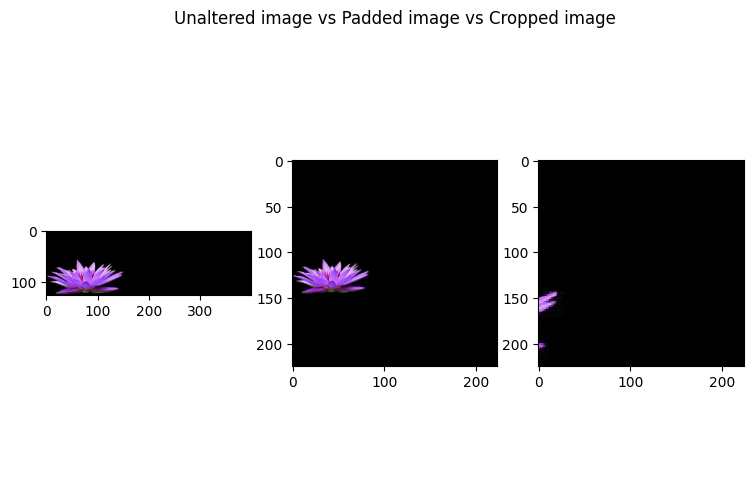

In [34]:
# Padding vs cropping
plt.figure(figsize=(9, 6))
plt.title('Unaltered image vs Padded image vs Cropped image')
plt.axis('off')
# Defining a path to an image that illustrates the difference between padding and cropping
image_path = train_dir + '\\Lilly\\334c1f79fd.jpg'

# Displaying unaltered image on the left
ax = plt.subplot(1, 3, 1)
img = mpimg.imread(image_path) / 255.0 # Read the image and normalise so it can be displayed properly with pyplot
plt.imshow(img)

# Displaying padded image in the centre
ax = plt.subplot(1, 3, 2)
img = tf.convert_to_tensor(img, dtype=tf.float32)  # resize_with_pad takes a tensor so we convert the image into one here
img = tf.image.resize_with_pad(img, 224, 224)  # generates black (0) padding where needed
plt.imshow(img.numpy())

# Displaying cropped image on the right
ax = plt.subplot(1, 3, 3)
img = utils.load_img(image_path, target_size=input_shape, keep_aspect_ratio=True)  # keep_aspect_ratio crops the image from the center
plt.imshow(img)

plt.show()


The next preprocessing step is <b>normalisation</b>. We will use min-max normalisation to make all pixel values from the range 0 - 255 to 0 - 1.

In [35]:
# Min-max normalisation
# x represents image data so we divide it by 255 to normalise each image's pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))

### 1.2 Data visualisation

Here we will visualise some of the data.<br>
First we will display a <b>sample image of each class</b> from the training dataset.
The images contain varying backgrounds and are of varying dimensions. But in our datasets we have scaled them all down to 224x224 and zero-padded them for use with our models.<br><br>
Next we will display the <b>class distribution</b> for the training dataset and the testing dataset. As can be seen, the training dataset is entirely evenly distributed, with each class having 400 training images. 80 images of each class are being reserved for validation in accordance with our 80/20 training/validation split. <br>
The testing dataset is also evenly distributed for the most part. The only minor difference is that there are 92 test images for the Daisy class and 89 for the Orchid class. Every other class has 100 test images each.



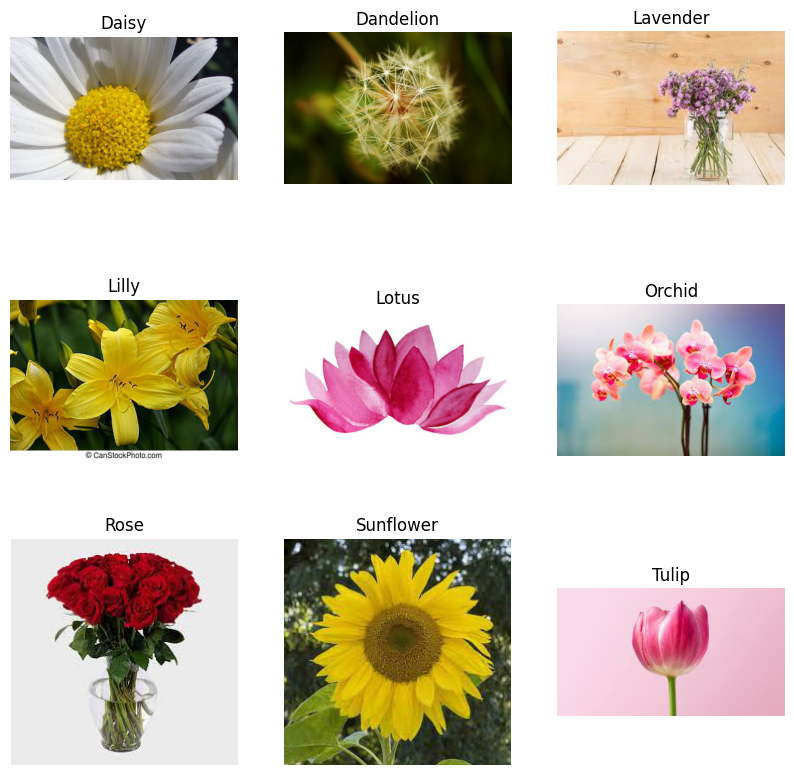

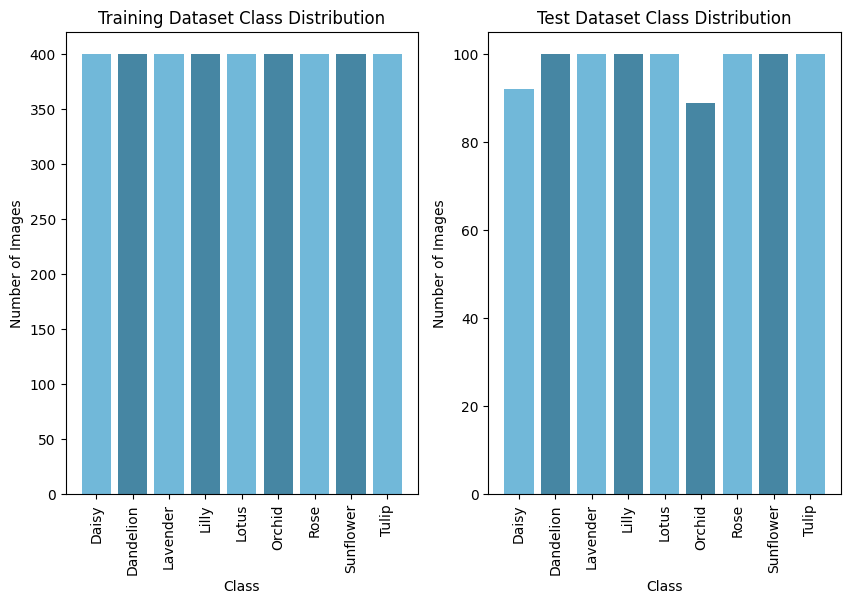

In [6]:
# Data visualisation

# Displaying sample images from the training dataset on a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# Flattening axes to easily loop through them
axes = axes.flatten()
# For each class name
for i, class_name in enumerate(class_names):
    image_file = os.listdir(train_dir + '\\' + class_name)[0] # This will get the first image filename in each class
    image_path = train_dir + '\\' + class_name + '\\' + image_file # Constructing the full path to the image
    img = mpimg.imread(image_path)
    axes[i].imshow(img) # Show each image
    axes[i].set_title(class_name) # Display the type of flower it is
    axes[i].set_axis_off()

# Visualising class distribution for the training dataset and the testing dataset
plt.figure(figsize=(10, 6))

# This array stores the number of images per class
class_distribution = []
for name in class_names:
    class_dir = os.path.join(train_dir, name) # This gets the path to each classes' directory
    class_distribution.append(len(os.listdir(class_dir)))  # This gives us the length of the array of files in class_dir

ax = plt.subplot(1, 2, 1)
# Displays a bar chart of the class distribution with alternating colours
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Training Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
# Rotating x ticks for readability
ax.tick_params(axis='x', labelrotation=90)

# Now we do the same with the testing dataset
class_distribution = []
for name in class_names:
    class_dir = os.path.join(test_dir, name)
    class_distribution.append(len(os.listdir(class_dir)))

ax = plt.subplot(1, 2, 2)
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Test Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.tick_params(axis='x', labelrotation=90)

## 2 The network structure and hyperparameters

### 2.1 GoogLeNet
Below are diagrams representing the architecture of GoogLeNet. <br>
![googlenet-architecture](https://drive.google.com/uc?id=1tWUNza79fQnQ-aJm-tc4hZw-aHEVCD5R) <br>
<i>GoogLeNet architecture</i> <br>
![inception-module](https://drive.google.com/uc?id=1RDRB1u-p2nup2MeYcCS9TkyXSbC_t6Qr) <br>
<i>Inception module</i> <br>
![auxiliary-classifier](https://drive.google.com/uc?id=145__39f0Z28chCQF0dGZ6IfeQKQt3Nvj) <br>
<i>Auxiliary classifier</i> <br><br>
GoogLeNet is a complex model that notably uses significantly less parameters than AlexNet through the use of inception modules. <br>
Inception modules have four paths that can capture different features which are then concatenated at the end. 1x1 convolutions are used to reduce the number of channels in the feature maps and to assist in deeper convolutions using ReLU activation. Then other operations can be performed, namely 3x3 convolution, 5x5 convolution and max-pooling which all serve to capture different patterns or features in the data. The convolutions of varying sizes can capture patterns at different scales while the pooling emphasises the most significant pixels in a region. All these operations use same-padding to retain their resolution as they are concatenated at the end, which essentially puts all their channels together, retaining all the information gleaned from these paths. For example if the 4 paths have a total of 50 channels combined, the output of concatenation would be their height x width x 50. <br>
An inception network such as GoogLeNet uses various inception modules often reducing their resolution as it gets deeper through the use of pooling with a stride greater than 1, often 2 to halve the resolution. This type of network allows for high performance with lower computational demands. The model we define in the below code cell has ~10,000,000 parameters, whereas AlexNet may have over 6 times that - a massive reduction in parameters thanks to inception modules. This design can also be considered intuitive as it aggregates visual information processed at different scales simultaneously meaning a richer set of features are learned. <br><br>
The GoogLeNet architecture makes use of inception modules to form a complex CNN alongside a few convolutional layers and pooling to reduce resolution as we go deeper. The input size is 224x224x3. While the model is about 27 layers deep the total number of layers is over 4 times the size since inception modules have simultaneous paths. We have added batch normalization after the convolutions with larger receptive fields in the architecture (outside of inception modules) to help with convergence. The final layers use average pooling to effectively flatten the feature map by getting the average value of the 7x7 input field which had resulted in improved accuracy for the authors of GoogLeNet. Lastly 40% dropout is used as a form of regularisation that reduces overfitting by forcing the model to learn a robust and complete set of features. Then lastly a fully-connected layer using softmax and 9 units generates our one-hot encoded output. <br><br>
Since the network is deep, there could be issues with backpropagating gradients. Auxiliary classifiers were introduced to tackle this and mitigate the effects of vanishing/exploding gradients. An auxiliary classifier are placed after the third and sixth inception modules since even at this point in the network there are some valuable features gleaned. This manages to ensure the gradient is propagated effectively while also not compromising classification performance. These auxiliary classifiers' losses are weighted at 0.3 of the main loss each to balance the training process. <br>
The auxiliary classifier consists of an average pooling layer, 1x1 convolutional layer, then flattens the feature map for a fully connected layer with 1024 units and 70% dropout is performed before the output fully connected layer. We have altered this to 50% as 70% seemed to be too high hindering our learning. <br><br>
He Normal weight initialisation is used since it is designed to improve performance for networks using ReLU activation which GoogLeNet does. Since ReLU can lead to sparse activations as all neurons 0 and below output only 0, so only positive neurons are active. He Normal initialisation improves the flow of gradient by initialising weights based on a normal distribution with mean of 0 and standard deviation of the root of 2 over the number of input neurons for the layer. This leads to higher variance which reduces the impact of sparse activation while also avoiding the other extreme of exploding gradients. <br><br>
The code block below also contains some preparatory code for fine-tuning our configuration which is explained in further depth under the <b>Optimisers</b> section. <br>
Our initial epoch value is 50 but we will see if so many epochs are needed by using a early stopping callback when we are no longer bettering our performance in training. This is explained more in later code blocks.

In [7]:
# This is a helper function that creates an optimiser with a specified learning rate (LR)
# This is used since we want to find the best combination of optimiser and LR
# As can be seen, we will be testing 4 optimisers: SGD, RMSProp, Adam, and Lion
def make_optimiser(optimiser, learning_rate):
    match(optimiser):
        case 'sgd':
            return SGD(learning_rate=learning_rate)
        case 'rmsprop':
            return RMSprop(learning_rate=learning_rate)
        case 'adam':
            return Adam(learning_rate=learning_rate)
        case 'lion':
            return Lion(learning_rate=learning_rate)

# Full GoogleNet architecture

# A helper function to easily define inception modules
def build_inception_module(input_layer, filters):
    # First path with 1 1x1 convolutional layer
    path1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)

    # Second path using a 3x3 convolutional layer with a 1x1 to reduce dimensionality
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=HeNormal())(path2)

    # Third path using a 5x5 convolutional layer with a 1x1 to reduce dimensionality
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer=HeNormal())(path3)

    # Fourth path using max pooling wih a 3x3 pool size to extract the most significant pixels followed by a 1x1 convolutional layer
    path4 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
    path4 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(path4)

    # Here we concatenate the layers into one layer with depth of the sum of the 4 paths.
    # So the depth of the concatenated layer will be filters[0] + filters[1][1] + filters[2][1] + filters[3]
    inception_layer = Concatenate(axis=-1)([path1, path2, path3, path4])
    return inception_layer

# A helper function to easily define auxiliary classifiers
def build_auxiliary_classifier(input_layer, name):
    # 5x5 average pooling with stride of 3 reducing the resolution by a third of the original
    aux = AvgPool2D(pool_size=(5, 5), strides=3, padding='valid')(input_layer)
    # A 1x1 convolutional layer to reduce dimensionality
    aux = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(aux)
    # Flattening for our fully connected layers
    aux = Flatten()(aux)
    # A fully connected layer with 1024 units using ReLU activation
    aux = Dense(units=1024, activation='relu', kernel_initializer=HeNormal())(aux)
    # 50% dropout (lowered from the 70% in the original GoogLeNet)
    aux = Dropout(rate=0.5)(aux)
    # Output using softmax and one-hot encoding
    aux = Dense(units=NB_CLASSES, activation='softmax', name=name)(aux)

    return aux

# This function builds all layers in the GoogLeNet architecture
def build_googlenet_model(tuner = None):
    # Input images are 224x224 with 3 channels for RGB
    input_layer = Input(shape=(224, 224, 3))

    # First some initial larger convolution is performed with a stride of 2, detecting larger patterns and halving our resolution
    layer = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    layer = BatchNormalization()(layer)
    # Again we simplify the input further with a max pooling of stride 2
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # Smaller convolution is performed here with a 1x1 and 3x3
    layer = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer=HeNormal())(layer)
    layer = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer=HeNormal())(layer)
    layer = BatchNormalization()(layer)
    # The resolution is reduced once more before the inception modules
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # 2 inception modules are used with different filter number configurations
    layer = build_inception_module(layer, [64, (96, 128), [16, 32], 32])
    layer = build_inception_module(layer, [128, (128, 192), [32, 96], 64])

    # Halving the resolution again, at this point the dimensions are 14x14x480
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [192, (96, 208), [16, 48], 64])
    # Our first auxiliary classifier is here and takes the feature maps from the last inception module (14x14x512)
    # This will help backpropagation of gradient to the previous layers
    auxiliary1 = build_auxiliary_classifier(layer, 'aux1')
    # Three more inception modules
    layer = build_inception_module(layer, [160, (112, 224), [24, 64], 64])
    layer = build_inception_module(layer, [128, (128, 256), [24, 64], 64])
    layer = build_inception_module(layer, [112, (144, 288), [32, 64], 64])
    # The second auxiliary classifier takes an input of 14x14x528
    auxiliary2 = build_auxiliary_classifier(layer, 'aux2')
    layer = build_inception_module(layer, [256, (160, 320), [32, 128], 128])

    # At this point we halve the resolution again using max pooling. Size is now 7x7x832
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [256, (160, 320), (32, 128), 128])
    # After this final inception module we will have 1024 7x7 feature maps
    layer = build_inception_module(layer, [384, (192, 384), (48, 128), 128])

    # This gets the average of the 7x7 field for each feature map resulting in 1x1x1024
    layer = AvgPool2D(pool_size=(7, 7), strides=1, padding='valid')(layer)
    layer = Flatten()(layer)
    # 40% dropout for robust learning
    layer = Dropout(0.4)(layer)
    # Finally we output our final one-hot encoded classification with softmax
    output_layer = Dense(units=NB_CLASSES, activation='softmax', name='output')(layer)

    # Now we create our model making sure to use the three outputs - the two auxiliary layers and the final output layer
    model = Model(inputs=input_layer, outputs=[output_layer, auxiliary1, auxiliary2], name='GoogLeNet')
    
    # If a tuner is specified we will use this code block to configure our optimiser & LR
    # Otherwise we skip this step and the model is compiled manually
    if tuner is not None:
        # These two choices give us 4x4 = 16 different combinations to test
        learning_rate = tuner.Choice('learning_rate', [0.001, 0.0001, 0.00005, 0.00001])
        optimiser_choice = tuner.Choice('optimiser', ['sgd', 'rmsprop', 'adam', 'lion'])
    
        # Here we initialise our optimiser using the results from the choices
        optimiser = make_optimiser(optimiser_choice, learning_rate)
    
        # We compile our model with the optimiser
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy', 'accuracy', 'accuracy'])
        
    return model

# Building a sample model to display a summary of the architecture                                               
googlenet = build_googlenet_model()
googlenet.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 10,331,979 (39.41 MB)

 Trainable params: 10,331,467 (39.41 MB)

 Non-trainable params: 512 (2.00 KB)

## 3 Loss Function
Since both models use one-hot encoding we chose to go with <b>categorical crossentropy</b> (CCE) which is best for one-hot encoded classification tasks. <br>
What this does is measures the sum of the probabilities assigned to incorrect classes since each incorrect class should be assigned a probability of 0, while the correct class should be assigned a probability of 1. <br>
Sparse categorical crossentropy is a similar loss function that achieves the same goal but for output encoded using numeric/ordinal encoding. <br>
Other loss functions such as root mean squared error or mean absolute error are better suited for regression tasks so we avoid using them here.
## 4 Optimiser
### 4.1 GoogLeNet Optimiser and Learning Rate Selection
There were four main optimisers that we investigated with our GoogLeNet architecture: Stochastic Gradient Descent (SGD), RMSProp, Adam, and Lion. <br>
- SGD was expected to be the least effective but serves as a baseline and also to test a gradient descent optimiser. Since our dataset has padding and noisy backgrounds it may take a long time to converge.
- RMSProp uses an adaptive learning rate and uses a moving average of squared gradients to adjust the learning rate.
- Adam is one of the most commonly used optimisers. It's similar to RMSProp in that it uses moving average as well but also considers momentum, the direction the gradients are moving in.
- Lion is a newer optimiser discovered by Google Brain. It considers momentum like Adam, but uses the sign operation making each parameter updated by the same magnitude. This makes it memory efficient and supposedly outperforms Adam.

While it seems that Lion may be the best optimiser, we will test each optimiser with learning rates: 0.001, 0.0001, 0.00005, and 0.00001 using Hyperband. Hyperband uses brackets to determine the best performing model, taking the best 50% of models to the next bracket. By putting models with each optimiser with each learning rate into a Hyperband tuner we can determine the best pair in a reasonable amount of time. We are comparing our models on validation loss.

In [8]:
# Instantiating our tuner to find the best performing optimiser and learning rate (LR) pair based on validation loss
tuner = kt.Hyperband(build_googlenet_model,
                     objective='val_loss',
                     max_epochs=epochs,
                     directory='googlenet',
                     project_name='GoogLeNet')

# Similar to fit, search will start training each model. It will only train for some epochs and then compare the results.
tuner.search(train_ds, validation_data=valid_ds, epochs=epochs, verbose=verbose)

# Gets the best optimiser and LR pair for use in subsequent models
best_pair = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'The best performing pair uses optimiser {best_pair.get('optimiser')} with learning rate {best_pair.get('learning_rate')}')

Trial 16 Complete [00h 01m 34s]
val_loss: 1.7669508457183838

Best val_loss So Far: 1.7669508457183838
Total elapsed time: 00h 26m 29s
The best performing pair uses optimiser lion with learning rate 0.0001


Lion with a LR of 0.0001 almost always ends up as the best performing optimiser. We will continue to use Lion, LR 0.0001 for cross-fold validation.

To determine a more optimal number of epochs to use in cross-fold validation we will use an early stopping callback. This callback keeps track of the highest validation accuracy. If this value has not been beaten in 5 epochs, then we stop training and use the epoch number where we achieved the highest validation accuracy as the 'best' number of epochs to train with.

In [13]:
# Now we can train a model with the best performing optimiser & LR pair to find an optimal number of epochs to use
# Build the model with the optimiser & LR
googlenet = build_googlenet_model()
# Instantiate the best performing optimiser & LR
optimiser = make_optimiser(best_pair.get('optimiser'), best_pair.get('learning_rate'))
# Compile our model with this optimiser
googlenet.compile(optimizer=optimiser,
                  loss={'output': 'categorical_crossentropy', 'aux1': 'categorical_crossentropy', 'aux2': 'categorical_crossentropy'},
                  loss_weights={'output': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  metrics=['accuracy', 'accuracy', 'accuracy'])

# This callback will stop training if validation accuracy has not seen a new max in 5 epochs (patience)
stop_early = EarlyStopping(monitor='val_output_accuracy', patience=5, verbose=1, mode='max')
# Now we train with 50 epochs which is likely more than needed in order to see how many epochs we actually should train with
history = googlenet.fit(train_ds, validation_data=valid_ds, epochs=epochs, batch_size=128, verbose=verbose, callbacks=[stop_early])

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 478ms/step - loss: 1.2829 - output_accuracy: 0.1943 - val_loss: 0.8713 - val_output_accuracy: 0.2347
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 508ms/step - loss: 0.6800 - output_accuracy: 0.4565 - val_loss: 0.6857 - val_output_accuracy: 0.3125
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 510ms/step - loss: 0.5020 - output_accuracy: 0.5392 - val_loss: 0.5850 - val_output_accuracy: 0.3542
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step - loss: 0.3894 - output_accuracy: 0.6225 - val_loss: 0.4764 - val_output_accuracy: 0.4889
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 507ms/step - loss: 0.3243 - output_accuracy: 0.6728 - val_loss: 0.4286 - val_output_accuracy: 0.5333
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 497ms/step - loss: 0.2695 - output_accuracy: 0.7219 - val_loss: 0.3200 - val_output_accuracy: 0.6403
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 506ms/step - loss: 0.2326 - output_accuracy: 0.7499 - val_loss: 0.3096 - val_output_accuracy: 0.6542

In [14]:
# Get the validation accuracy for each epoch
val_accuracy_by_epoch = history.history['val_output_accuracy']
# Find the epoch number with the highest validation accuracy (+1 since arrays start at 0)
# Reassign epochs as this is now the number we will use for future training
epochs = val_accuracy_by_epoch.index(max(val_accuracy_by_epoch)) + 1
print(f'The model had the best validation accuracy after {epochs} epochs')

The model had the best validation accuracy after 18 epochs


## 5 Cross-fold validation
### 5.1 GoogLeNet
For GoogLeNet we are performing k-fold validation using 5 folds. This will train 5 models with an 80/20 train/val split where the validation split will represent a unique fifth for each model. Using different splits for validation can be useful in that different training data may provide better generalisation and we can also aggregate our results to make more balanced predictions. This is of course at the expense of greater computational demands since we have to train 5 models instead of just 1.<br>
We are using the epoch value and optimiser, learning rate pair that has worked best for us so far. <br>
We will also track the training for each model and save each model so that we can evaluate them. Cross-fold validation can produce different models and some may perform better. We can either choose the best model to use if we want or we can try aggregate the predictions of all of our models and see if that performs better.

In [18]:
# Training models with Cross Fold Validation

# We will need all of the training data for this so we load it in
full_train_ds = load_dataset(train_dir)

# Splits corresponds to the number of folds
splits = 5
# Total number of elements in the training data
dataset_size = len(list(full_train_ds))
# The number of elements in each fold
fold_size = dataset_size // splits
# The results and predictions of each fold will be stored in these arrays
googlenet_scores = []
# Store the models for evaluation later
googlenet_models = []

# For each fold we will split the training data into 5 parts, 4 for training and 1 for validation and repeat for each possible permutation (5)
for fold in range(splits):
    # Create a new model
    googlenet = build_googlenet_model()
    # Re-instantiate the optimiser
    optimiser = make_optimiser(best_pair.get('optimiser'), best_pair.get('learning_rate'))
    googlenet.compile(optimizer=optimiser,
                  loss={'output': 'categorical_crossentropy', 'aux1': 'categorical_crossentropy', 'aux2': 'categorical_crossentropy'},
                  loss_weights={'output': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  metrics=[['accuracy', 'precision', 'recall'], ['accuracy', 'precision', 'recall'], ['accuracy', 'precision', 'recall']])
    # Train the model with the specific training sets and validation set
    # Get the 'fold'th' fifth of the training data for validation (either the 1st, 2nd, 3rd, 4th, or 5th fifth)
    valid_fold = full_train_ds.skip(fold * fold_size).take(fold_size)
    # Get the remaining training data for training (gets the data after the validation split and concatenates with the data before the validation split)
    train_fold = full_train_ds.skip((fold+1) * fold_size).concatenate(full_train_ds.take(fold * fold_size))
    
    # Save the scores from the training
    googlenet_scores.append(googlenet.fit(train_fold, epochs=epochs, validation_data=valid_fold, batch_size=128, verbose=verbose))
    # Store the model
    googlenet_models.append(googlenet)
    # Save the model
    googlenet.save(f'./googlenet_models/model{fold+1}.keras')


Found 3600 files belonging to 9 classes.
Epoch 1/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 46s 429ms/step - loss: 1.4919 - output_accuracy: 0.1587 - output_precision: 0.1504 - output_recall: 0.0279 - val_loss: 0.8246 - val_output_accuracy: 0.3466 - val_output_precision: 0.5769 - val_output_recall: 0.1065
Epoch 2/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - loss: 0.6983 - output_accuracy: 0.4155 - output_precision: 0.6621 - output_recall: 0.1729 - val_loss: 0.6485 - val_output_accuracy: 0.4105 - val_output_precision: 0.6187 - val_output_recall: 0.2443
Epoch 3/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - loss: 0.5150 - output_accuracy: 0.5260 - output_precision: 0.7179 - output_recall: 0.3257 - val_loss: 0.4822 - val_output_accuracy: 0.5497 - val_output_precision: 0.7379 - val_output_recall: 0.2599
Epoch 4/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - loss: 0.4110 - output_accuracy: 0.6030 - output_precision: 0.7378 - output_recall: 0.4096 - val_loss: 0.3755 - val_output_accuracy: 0.6236 - val_

## 6 Results
We assessed our models based on three main metrics: accuracy, precision, and recall. Loss was also measured to get an idea of the models' performance. We tracked the models' progress during and after training. <br>
- Accuracy was used since our datasets are balanced so a measure of how often a prediction is correct will give us a good idea of how well the models' perform for all classes.
- Precision measures how often positive predictions are correct. This can be useful for imbalanced datasets but in our case, we can expect it to be close to our accuracy.
- Recall measures how often positive instances were found. Using recall in combination with precision should give a decent idea of where a model loses performance. For this reason f1-score would also be an appropriate metric since it combines precision and recall. We have them separate to see any notable differences between precision and recall.

In this section of the report we will describe the methods of gathering results and visualisations performed. We will discuss the implications of these results in further detail in the <b>Evaluation</b> section.
### 6.1 GoogLeNet
First we plot the metrics and loss for training and validation for each model in our cross fold validation. <br>
- Training accuracy was on average around 88% however validation accuracy was lower at around 80%. Interestingly the strategy of finding an optimal number of epochs seems to have worked as a some models peaked 1 or 2 epochs before the final one.
- Training loss was almost identical across the models at about 0.1 while there was a lot more variance in validation loss which fluctuated around the last few epochs. The average final validation loss was 0.233.
- Precision was similar to accuracy as expected with average training precision of 92%, and an average validation precision of 83%, lower by near the same amount as accuracy.
- Recall scored slightly lower than the other metrics at 85% for training and 76% for validation.

Interestingly validation scores were be lower by almost the exact same amount for each metric. Training scores were much closer together for each model while validation scores were more varied as to be expected. When comparing validation scores, model 5 performed best by every metric while having the second best loss.


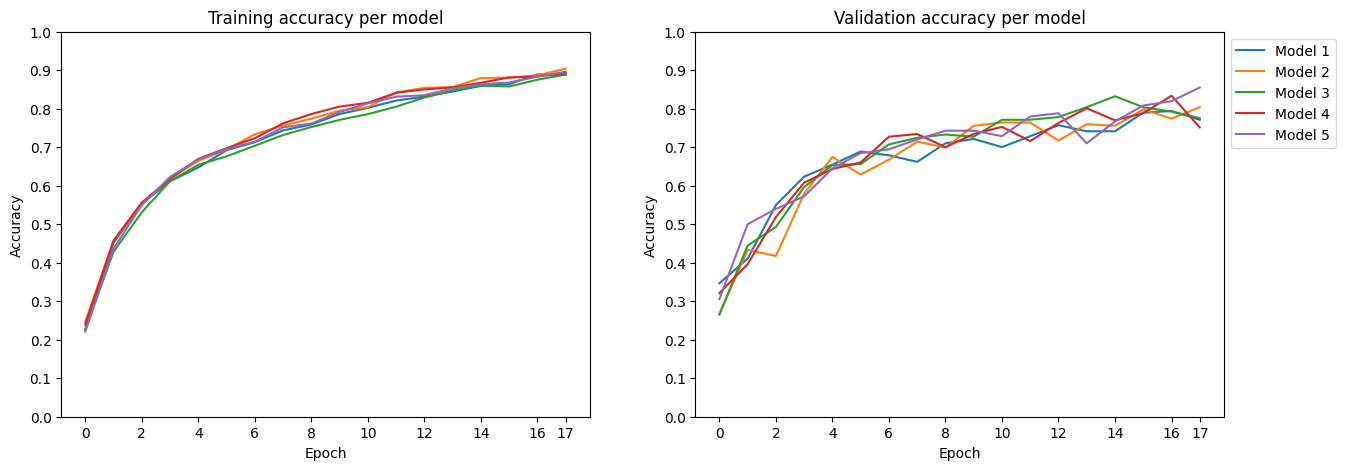

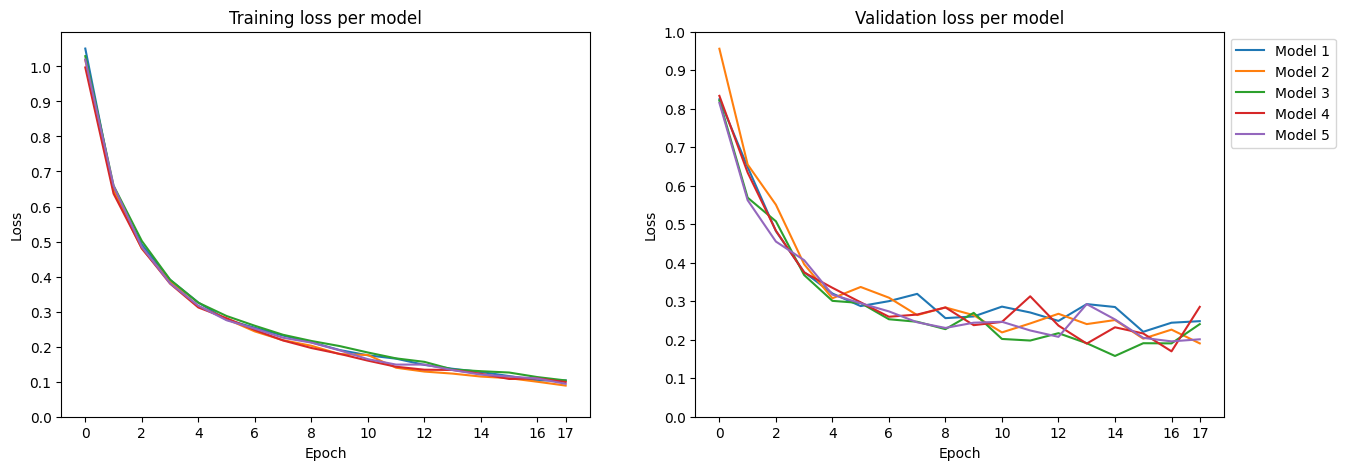

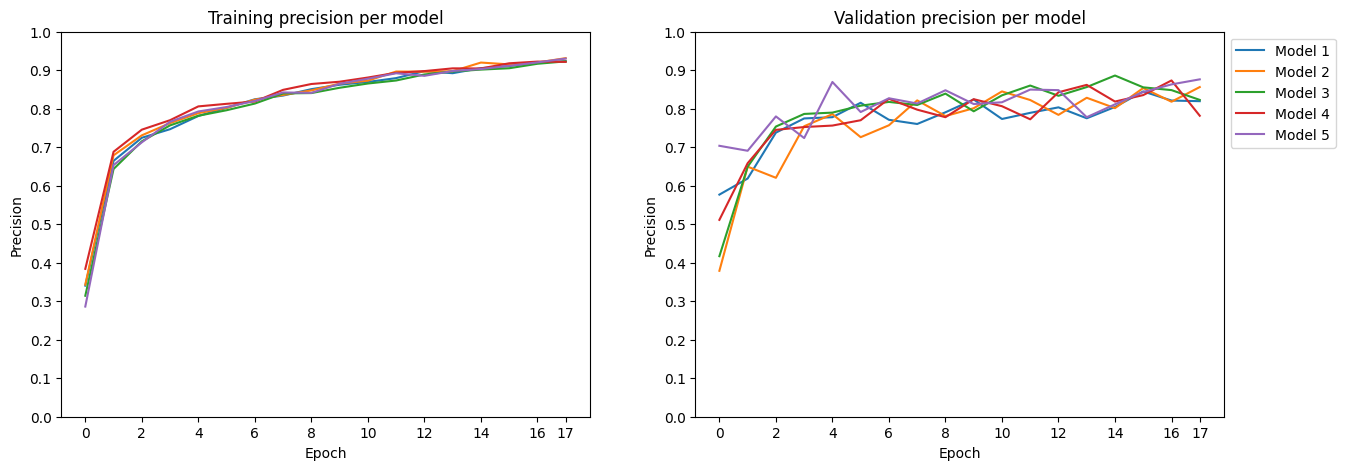

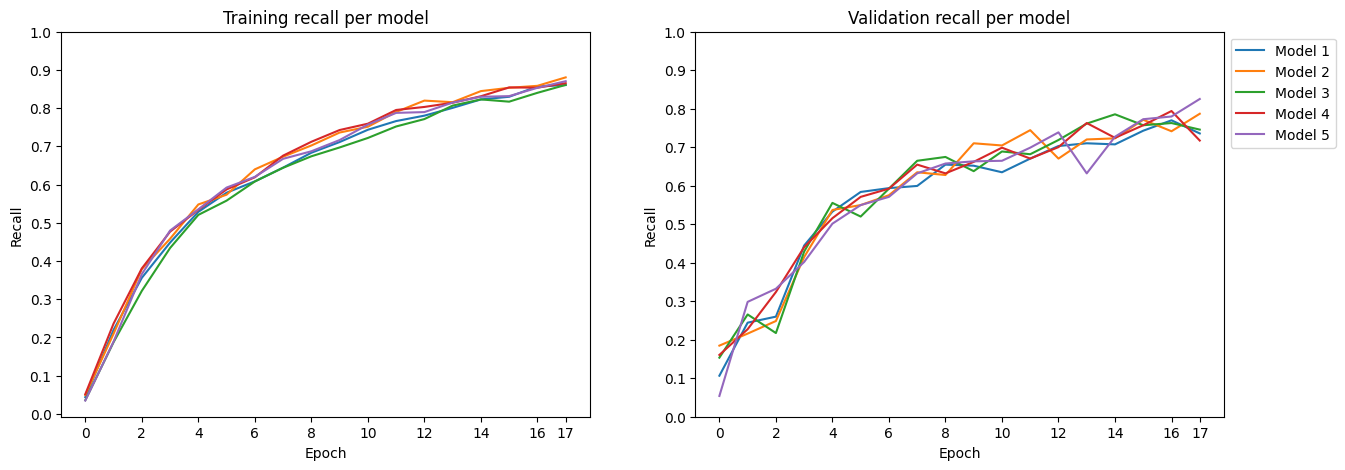

In [20]:
# Visualising training results over time
# Helper function to make plots easily for different metrics
def plot_googlenet_scores(ax, metric, title, ylabel):
    # Plot the score for each model from 5-fold
    for history in googlenet_scores:
        ax.plot(history.history[metric])
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 17])
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.figure(figsize=(15, 5))
# Training accuracy
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'output_accuracy', 'Training accuracy per model', 'Accuracy')

# Validation accuracy
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_output_accuracy', 'Validation accuracy per model', 'Accuracy')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(15, 5))
# Training loss
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'loss', 'Training loss per model', 'Loss')

# Validation loss
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_loss', 'Validation loss per model', 'Loss')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(15, 5))
# Training precision
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'output_precision', 'Training precision per model', 'Precision')

# Validation precision
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_output_precision', 'Validation precision per model', 'Precision')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(15, 5))
# Training recall
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'output_recall', 'Training recall per model', 'Recall')

# Validation recall
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_output_recall', 'Validation recall per model', 'Recall')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Now, we will evaluate each of our models against the test set and print out their results. At the end we will also get the average of each metric and loss. 

In [40]:
# Evaluate each model and print the results
def print_evaluation(name, evaluation):
    print(f'{name} test loss: {round(evaluation[0], 4)}')
    print(f'{name} test accuracy: {round(evaluation[1]*100, 1)}%')
    print(f'{name} test precision: {round(evaluation[2]*100, 1)}%')
    print(f'{name} test recall: {round(evaluation[3]*100, 1)}%')
    
googlenet_evaluations = []

# Printing test results for each model
for idx, model in enumerate(googlenet_models):
    evaluation = model.evaluate(test_ds)
    print_evaluation(f'GoogLeNet {idx+1}', evaluation)
    googlenet_evaluations.append(evaluation)

# Getting the average evaluation scores for all models
googlenet_evaluations = np.sum(googlenet_evaluations, axis=0)
avg_loss = round((googlenet_evaluations[0] / 5), 4)
avg_accuracy = round((googlenet_evaluations[1] / 5), 4)
avg_precision = round((googlenet_evaluations[2] / 5), 4)
avg_recall = round((googlenet_evaluations[3] / 5), 4)

# Print the average metrics
print(f'\nAverage loss: {avg_loss}')
print(f'Average accuracy: {avg_accuracy*100}%')
print(f'Average Precision: {avg_precision*100}%')
print(f'Average Recall: {avg_recall*100}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.6757 - output_accuracy: 0.5380 - output_precision: 0.5978 - output_recall: 0.5106
GoogLeNet 1 test loss: 0.667
GoogLeNet 1 test accuracy: 55.5%
GoogLeNet 1 test precision: 60.6%
GoogLeNet 1 test recall: 52.1%
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.6890 - output_accuracy: 0.6020 - output_precision: 0.6441 - output_recall: 0.5625
GoogLeNet 2 test loss: 0.66
GoogLeNet 2 test accuracy: 61.6%
GoogLeNet 2 test precision: 65.2%
GoogLeNet 2 test recall: 57.2%
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.7131 - output_accuracy: 0.5680 - output_precision: 0.6011 - output_recall: 0.5259
GoogLeNet 3 test loss: 0.7
GoogLeNet 3 test accuracy: 56.5%
GoogLeNet 3 test precision: 60.5%
GoogLeNet 3 test recall: 53.0%
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.7580 - output_accuracy: 0.5956 - output_precision: 0.6241 - output_recall: 0.5789
GoogLeNet 4 test loss: 0.742
GoogLeNet 4 test accuracy: 58.8%
GoogLeNet 4 test precision: 

We will now try aggregating the predictions made by each model and comparing the results of that against the individual models' results. <br>
To do this, we will use majority voting. For each prediction, we will take the most commonly predicted class by our models and use that as the aggregated prediction for that instance. In the case of a tie, we will just take the first tied class and use that. 

In [58]:
# Aggregating our models to get an average prediction

# Extracting test images and labels from the dataset
X_test = [] # Array of images
y_test = [] # Array of labels corresponding to the images
for x_t, y_t in test_ds:
    for i in range(x_t.shape[0]):
        X_test.append(x_t[i].numpy())
        y_test.append(y_t[i].numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)
# True labels
y_true = np.argmax(y_test, axis=1)

# Get the predictions for each model for the test data
googlenet_predictions = []
for model in googlenet_models:
    prediction = model.predict(X_test)
    googlenet_predictions.append(np.array(prediction[0]))

# To get the average predicted label we first average the predictions
avg_googlenet_predictions = np.mean(googlenet_predictions, axis=0)
# Then we get the highest mean probablity for each classification
avg_googlenet_predictions = np.argmax(avg_googlenet_predictions, axis=1)
# Now we can calculate the metrics
print('\nResults for the average prediction made by all models')
print(f'Accuracy: {accuracy_score(y_true, avg_googlenet_predictions)*100:.4f}%')
print(f'Precision: {precision_score(y_true, avg_googlenet_predictions, average='macro')*100:.4f}%')
print(f'Recall: {recall_score(y_true, avg_googlenet_predictions, average='macro')*100:.4f}%')

# We will also get the most commonly predicted label by a majority vote
# First we get the most commonly predicted label for each model
majority_googlenet_predictions = np.array([np.argmax(prediction, axis=1) for prediction in googlenet_predictions])
# Then we get the mode (most commonly predicted label) for all the models
majority_googlenet_predictions, _ = mode(majority_googlenet_predictions, axis=0)

print('\nResults for the majority prediction made by all models')
print(f'Accuracy: {accuracy_score(y_true, majority_googlenet_predictions)*100:.4f}%')
print(f'Precision: {precision_score(y_true, majority_googlenet_predictions, average='macro')*100:.4f}%')
print(f'Recall: {recall_score(y_true, majority_googlenet_predictions, average='macro')*100:.4f}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step

Results for the average prediction made by all models
Accuracy: 65.7208%
Precision: 62.0294%
Recall: 65.8514%

Results for the majority prediction made by all models
Accuracy: 64.4722%
Precision: 61.2207%
Recall: 64.6485%


Create confusion matrix

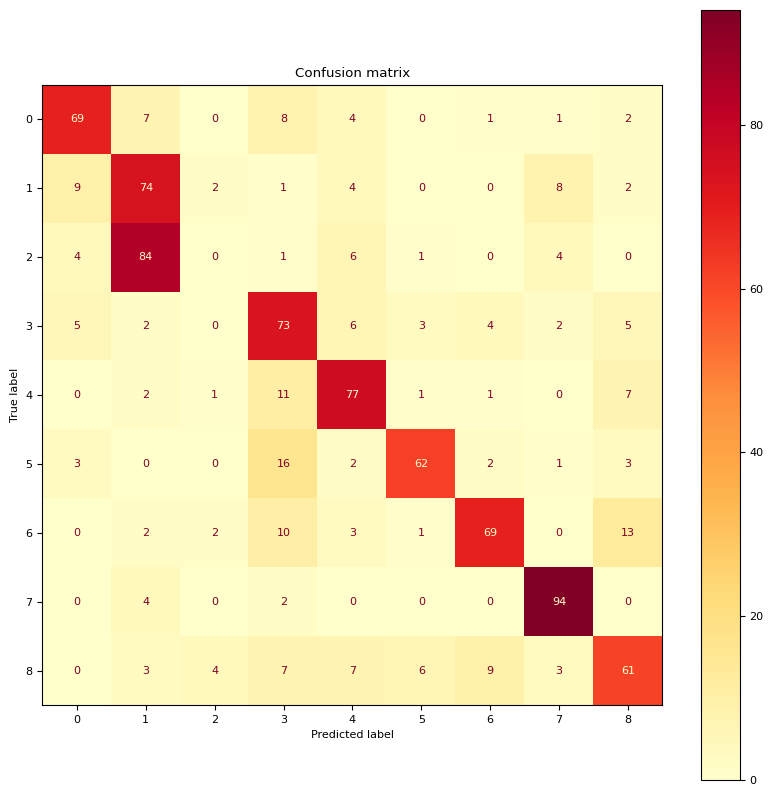

In [68]:
# Computing confusion matrix
cm = confusion_matrix(y_true, avg_googlenet_predictions)
classes = [str(i) for i in range(NB_CLASSES)]
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({"font.size": 8})

# Plotting confusion matrix
cm_display.plot(ax=ax, cmap="YlOrRd")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

## 7 Evaluation

## 8 References:
Our dataset: <br>
[National Flowers](https://www.kaggle.com/datasets/shahidulugvcse/national-flowers) <br><br>
Additional lavender test images sources: <br>
https://unsplash.com/s/photos/lavender <br>
https://www.pexels.com/search/lavender <br><br>
GoogLeNet paper: <br>
[Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842) <br><br>
GoogLeNet example implementation: <br>
[Implementation of GoogLeNet on Keras](https://lekhuyen.medium.com/implementation-of-googlenet-on-keras-d9873aeed83c) <br><br>
Keras Tuner (Hyperband): <br>
[Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) <br><br>
TensorFlow Documentation: <br>
[API Documentation | TensorFlow v2.16.1](https://www.tensorflow.org/api_docs) <br><br>
Matplotlib documentation: <br>
[Matplotlib Docs](https://matplotlib.org/stable/) <br><br>
Keras Documentation: <br>
[Keras 3 API documentation](https://keras.io/api/)